In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

/opt/anaconda3/envs/tf-1.10/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/tf-1.10/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/tf-1.10/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/tf-1.10/lib/python3.6/site-packages/tensorflow/

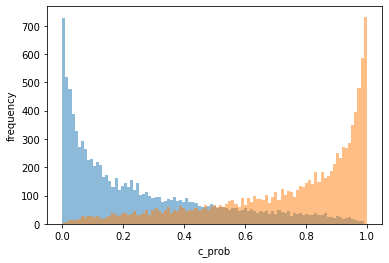

x has shape (20000, 30) 

coefficient values:
 0.4    12
-0.0     7
-0.4     5
-0.8     4
 0.8     2
dtype: int64 

c has shape (20000,) 

c values
1    10063
0     9937
dtype: int64 



In [2]:
# simulate condition c as a function of covariates x

n_features = 30
n_examples = 20000

x = np.random.randn(n_examples, n_features)
xc_coeffs = .4 * np.round(np.random.randn(n_features))
c_logits = np.squeeze(x @ xc_coeffs[:, np.newaxis])

def logistic(x): return 1 / (1 + np.exp(-1 * x))

c_prob = logistic(c_logits)
c = (np.random.rand(n_examples) < c_prob).astype(int)

plt.hist(c_prob[c == 0], bins=np.linspace(0, 1, 100), alpha=.5)
plt.hist(c_prob[c == 1], bins=np.linspace(0, 1, 100), alpha=.5)
plt.xlabel('c_prob')
plt.ylabel('frequency')
plt.show()

print('x has shape', np.shape(x), '\n')
print('coefficient values:')
print(pd.value_counts(xc_coeffs), '\n')
print('c has shape', np.shape(c), '\n')
print('c values')
print(pd.value_counts(c), '\n')

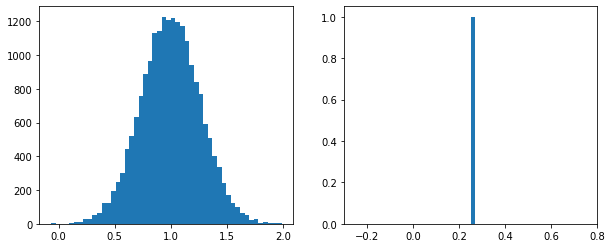

In [3]:
# simulate event times as a function of c and x with uniform censoring

max_time = 10

xmu_coeffs = .05 * np.round(np.random.randn(n_features))
mu_event = np.squeeze(1 + (x @ xmu_coeffs[:, np.newaxis]))

#xsigsq_coeffs = .02 * np.round(np.random.randn(n_features))
#sigsq_event = np.squeeze(x @ xsigsq_coeffs[:, np.newaxis])

sigsq_event = .25

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(mu_event, bins=50)
ax[1].hist(sigsq_event, bins=50)
plt.show()

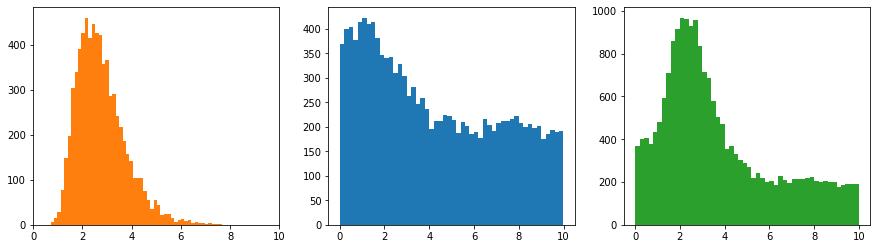

In [4]:
event_times = np.exp(mu_event + sigsq_event * np.random.randn(n_examples)) + max_time * (1 - c)
censoring_times = max_time * np.random.rand(n_examples)

t = np.minimum(event_times, censoring_times)
s = (t == event_times).astype(int)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].hist(t[s == 1], color='C1', bins=50)
ax[0].set_xlim([0, 10])
ax[1].hist(t[s == 0], color='C0', bins=50)
ax[2].hist(t, color='C2', bins=50)
plt.show()

In [5]:
import sys
sys.path.append('../src')
from model import CFTModel

In [6]:
val_idx = 4 * n_examples // 5

x_train = x[:val_idx]
t_train = t[:val_idx][:, np.newaxis]
s_train = s[:val_idx][:, np.newaxis]
c_train = c[:val_idx]

x_val = x[val_idx:]
t_val = t[val_idx:][:, np.newaxis]
s_val = s[val_idx:][:, np.newaxis]
c_val = c[val_idx:]

Completed Epoch 0
Completed Epoch 10
Completed Epoch 20
Completed Epoch 30
Completed Epoch 40
Completed Epoch 50
Completed Epoch 60
Completed Epoch 70
Completed Epoch 80
Completed Epoch 90
Completed Epoch 100
Completed Epoch 110
Completed Epoch 120
Completed Epoch 130
Completed Epoch 140
Completed Epoch 150
Completed Epoch 160
Completed Epoch 170
Completed Epoch 180
Completed Epoch 190
Completed Epoch 200
Completed Epoch 210
Completed Epoch 220
Completed Epoch 230


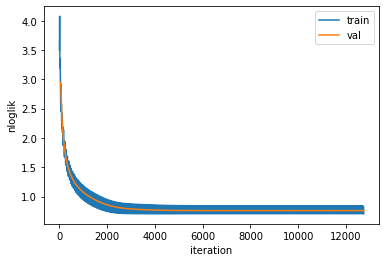

In [7]:
mdl = CFTModel()
with tf.Session() as sess:
    train_stats, val_stats = mdl.train(
        sess, x_train, t_train, s_train, x_val, t_val, s_val,
        2000, max_epochs_no_improve=10, learning_rate=1e-3)
    c_pred = mdl.predict_c(sess, x_val)
    c_weights = mdl.get_c_weights(sess)
    t_pred = mdl.predict_t(sess, x_val)
    
train_stats = list(zip(*train_stats))
val_stats = list(zip(*val_stats))

plt.plot(train_stats[0], train_stats[1], label='train')
plt.plot(val_stats[0], val_stats[1], label='val')
plt.xlabel('iteration')
plt.ylabel('nloglik')
plt.legend()
plt.show()

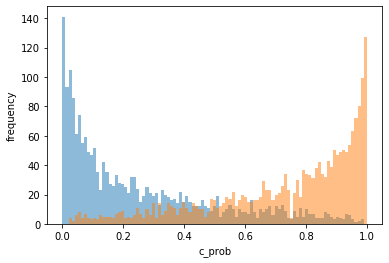

In [8]:
plt.hist(c_pred[c_val == 0], bins=np.linspace(0, 1, 100), alpha=.5)
plt.hist(c_pred[c_val == 1], bins=np.linspace(0, 1, 100), alpha=.5)
plt.xlabel('c_prob')
plt.ylabel('frequency')
plt.show()

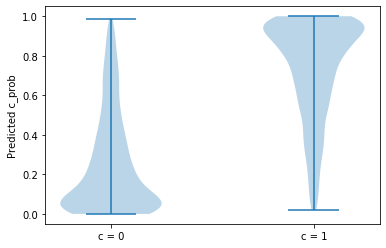

In [9]:
plt.violinplot([c_pred[c_val == 0], c_pred[c_val == 1]])
plt.xticks([1, 2], ['c = 0', 'c = 1'])
plt.ylabel('Predicted c_prob')
plt.show()

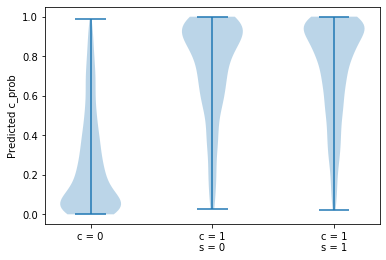

In [10]:
plt.violinplot([
    c_pred[c_val == 0],
    c_pred[(c_val == 1) & np.squeeze(s_val == 0)],
    c_pred[(c_val == 1) & np.squeeze(s_val == 1)]])
plt.xticks([1, 2, 3], ['c = 0', 'c = 1\ns = 0', 'c = 1\ns = 1'])
plt.ylabel('Predicted c_prob')
plt.show()

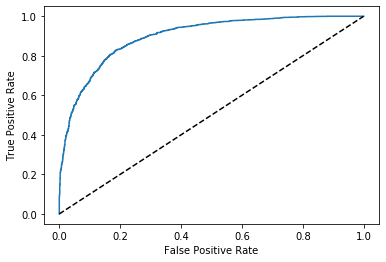

AUC = 0.90
Optimal AUC = 0.90


In [11]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(c_val, c_pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

print('AUC = %.2f' % roc_auc_score(c_val, c_pred))
print('Optimal AUC = %.2f' % roc_auc_score(c_val, c_prob[val_idx:]))

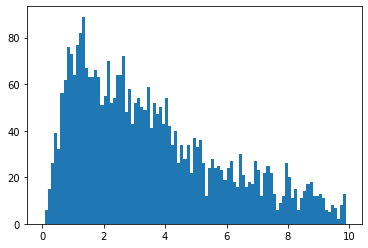

In [12]:
plt.hist(t_pred, bins=np.arange(100) / 10)
plt.show()

# Issues

- nature of penalty. is there a more principled way to choose this?
- when using NN, it will predict everyone is positive (to avoid penalty, presumably)
- dealing with variance of lognormal distribution

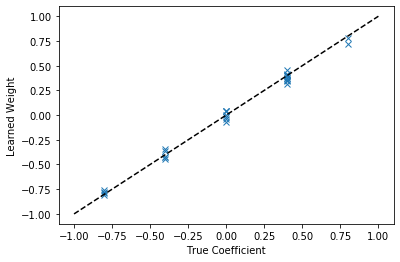

In [13]:
plt.plot(xc_coeffs, c_weights, 'x')
plt.plot([-1, 1], [-1, 1], 'k--')
plt.xlabel('True Coefficient')
plt.ylabel('Learned Weight')
plt.show()

We know what the optimal AUC is: comes from the Bernoulli. Need to state this.

- dropout to inputs as well

- might be better to have complexity in f rather than in p(c) (put the 'load' on the decoder)

- check the logpdf

- go back to AFT model -- will show how to treat variance?

- go back to the model. how do we define penalty?

- implement the ARM

- MIMIC: find the right outcomes, pick 2-3 things, maybe more. think about competing risks versus independent
- Twitter